# TODO:
GENERAL: Add more explanations and sources, including pointers to where inspiration has been drawn from

1. Split forward and backward pass into multiple cells and pretty print
2. Unkok
3. Add math explanations to forward and backward pass
4. Draw the network architecture in drawio
5. EXPERIMENT!!!!
6. Make data generator
7. Do multiple forward and backward passes automatically
8. Save trained network parameters as an introductory example

Experimentation suggestions from Frank:
* Experiment with different activation functions (AFs) and loss/cost functions (LF/CF) (including regression and MSE).
* Experiment with input/output tensors with depth > 1  (i.e. 2).
* Experiment with a batch size > 1 (i.e. 2).


# Problem formulation (If there is time)
The problem at hand is a binary classification task between two tetris pieces, the "I" and the "O". These pieces were chosen since they neatly represent "1" and "0" graphically (which will be their embedding in this problem). To classify images with "I" or "O" in them, images in the form of 4x4x1 matrices are fed to a CNN+FCNN, the performance of which is determined with binary cross-entropy and trained using stochastic gradient descent.

# Actual problem description as of now:
4x4 images are generated from two different distributions, distribution "I" and "O". The network should learn how to distinguish between the two distributions

# Given
1. The network architecture  

| **Layer**   | **Input dim** | **Output dim** | **Other**                                                  |
|-------------|---------------|----------------|------------------------------------------------------------|
| Input       | 4x4           | 4x4            | "I" or "O" in input                                        |
| 2D convolve | 4x4           | 3x3            | Kernel: 2x2 with stride 1 and no padding. Activation: ReLU |
| Max pool    | 3x3           | 2x2            | Kernel: 2x2 with stride 1 and no padding.                  |
| Flatten     | 2x2           | 4x1            |                                                            |
| FCNN        | 4x1           | 1              | Activation: Sigmoid                                        |

which has a total of 10 parameters, decomposed into 2 biases from the CNN and FCNN, 4 kernel weights in the CNN and 4 weights in the FCNN.

2. An input matrix *X* and a label *y*, where *y* = 0 when *X* contains "O" and *y* = 1 when *X* contains "I"

# Find
1. The intermediate values in the network
2. Post-activation for a forward pass
3. Loss for a forward pass
3. Gradient of the loss function w.r.t. the network parameters


# Imports and helper functions

In [120]:
import numpy as np

import matplotlib.pyplot as plt

from dataclasses import dataclass

from __future__ import annotations
from itertools import product


class Matrix2D():

    def __init__(self, array: np.ndarray):
        assert len(array.shape) == 2, "Input array must be 2D!"

        self.data: np.ndarray = array
        self.nrow: int = array.shape[0]
        self.ncol: int = array.shape[1] 

    def __getitem__(self, key):
        return self.data[key]

    def __setitem__(self, key, val):
        self.data[key] = val

    def draw(self, title: str = "") -> None:
        """Display a visualization of the matrix values

        See: https://stackoverflow.com/questions/40887753/display-matrix-values-and-colormap
        """
        fig, ax = plt.subplots()

        ax.matshow(self.data, cmap=plt.cm.Blues)

        if self.nrow == 1:
            for col in range(self.ncol):
                ax.text(col, 0, f"{self.data[0, col]:.2f}", va='center', ha='center')
        elif self.ncol == 1:
            for row in range(self.nrow):
                ax.text(0, row, f"{self.data[row, 0]:.2f}", va='center', ha='center')
        else:
            for col, row in np.ndindex(self.data.shape):
                ax.text(col, row, f"{self.data[row, col]:.2f}", va='center', ha='center')


        ax.set_title(title)


    # TODO: Fix padding
    def convolve2D(self, kernel: Matrix2D, bias: float = 0, stride: int = 1) -> Matrix2D:
        """Convolve the 2D matrix with a 2D kernel plus bias

        See http://www.songho.ca/dsp/convolution/convolution2d_example.html for the math
        """
        assert stride != 0, "Stride cannot be zero!"

        output_width: int = (self.nrow - kernel.nrow) // stride + 1
        output_height: int = (self.ncol - kernel.ncol) // stride + 1

        output_image = np.zeros((output_height, output_width))

        for col, row in product(range(0, output_width, stride), range(0, output_height, stride)):
            output_image[row, col] = \
                self.data[row:row+kernel.ncol, col:col+kernel.nrow].flatten() \
                @ kernel.data.flatten() \
                + bias 

        return Matrix2D(output_image)

    def maxpool(self, ndim: int = 1, stride: int = 1):
        """Dimension reduction using the max of a neigborhood defined by ndim

        See https://computersciencewiki.org/index.php/Max-pooling_/_Pooling for the math
        and https://datascience.stackexchange.com/questions/11699/backprop-through-max-pooling-layers
        for the intuition on why the indices of the maximum values for each pool is needed
        """
        assert stride != 0, "Stride cannot be zero!"

        output_width: int = (self.nrow - ndim) // stride + 1
        output_height: int = (self.ncol - ndim) // stride + 1

        output_image = np.zeros((output_height, output_width))
        indices = []

        for row, col in product(range(output_width), range(output_height)):
            rows = slice(row * ndim, (row+1) * ndim)
            cols = slice(col * ndim, (col+1) * ndim)
            pool = self.data[rows, cols]

            output_image[row, col] = np.max(pool)

            index = np.add(np.unravel_index(np.argmax(pool), pool.shape), (row * col, col * row))
            indices.append(index)
        
        return Matrix2D(output_image), indices

    def flatten(self):
        return Matrix2D(self.data.flatten().reshape(self.nrow*self.ncol, 1))



# TODO: Make compatible with arrays and matrices?
# TODO: Alternatively remove class and just pass bool
@dataclass
class Network():
    weights: np.ndarray = np.empty(0)
    bias: float = 0.0
    backward: bool = False

    def forward(self, x):
        return self.weights @ x + self.bias

    def relu(self, value):
        """ReLU activation"""
        act = value > 0

        if self.backward:
            return act * 1

        return act * value

    def sigmoid(self, value):
        """Sigmoid activation"""
        act = np.exp(value) / (1 + np.exp(value))

        if self.backward:
            return act * (1 - act)

        return act

    def binary_cross_entropy(self, y: float, p: float) -> float:
        """Binary cross entropy loss calculation

        See: https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html
        """
        if self.backward:
            return (1 - y) / (1 - p) - (y / p)

        return  - (y * np.log10(p) + (1 - y) * np.log10(1 - p))



# Initialize parameters

In [121]:
# Learned parameters for the CNN
K = Matrix2D(np.array(([[1, -1, 1], [0, 0, 0], [-1, 1, -1]]),  dtype=np.float64)) # TODO: Initialize random???
b1 = 1.0

# Learned parameters for the FNN
w = np.random.uniform(low=-1, high=1, size=(1, 4))
b2 = 1.0

# Initialize network
nn = Network(weights=w, bias = b2)


# Data

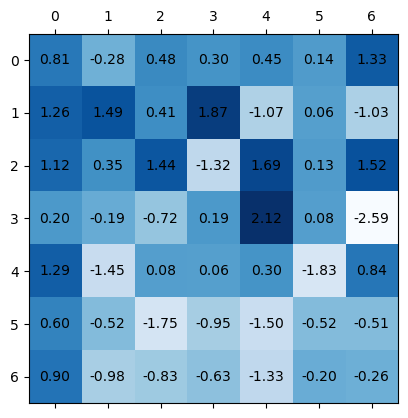

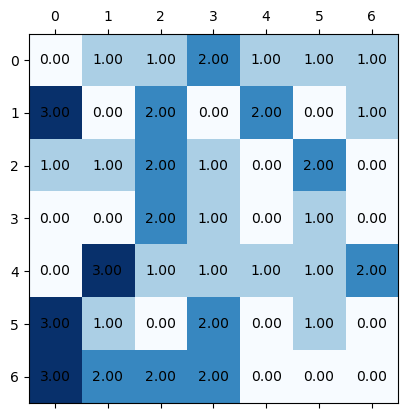

In [122]:
# # DATA
# X = Matrix2D(np.zeros((4, 4)))
# X[:4, 2] = 1
# y = 1 #"O" = 0 and "I" = 1
# print(f"y = {y}")
# X.draw("Image of I block")

ndim = 7
# Distribution 0
y = 0
X = Matrix2D(np.random.normal(0, 1, (ndim, ndim)))
X.draw()

# Distribution 1
y = 1
X = Matrix2D(np.random.poisson(1.0, (ndim, ndim)))
X.draw()



# X = Matrix2D(np.zeros((4, 4)))
# X[1:3, 1:3] = 1
# y = 0
# X.draw("Example image of O block")

# Forward pass

In [123]:
# z: pre-activation variable
# a: post-activation variable

nn.backward = False
print(f"Network parameters: K = {K.data.flatten()}, b1 = {b1}, w = {nn.weights[0]}, b2 = {nn.bias}")

Network parameters: K = [ 1. -1.  1.  0.  0.  0. -1.  1. -1.], b1 = 1.0, w = [-0.52839892 -0.12049472 -0.43016115 -0.71605281], b2 = 1.0


#### Convolution with ReLU

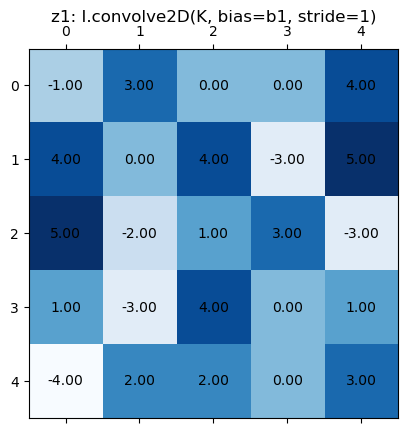

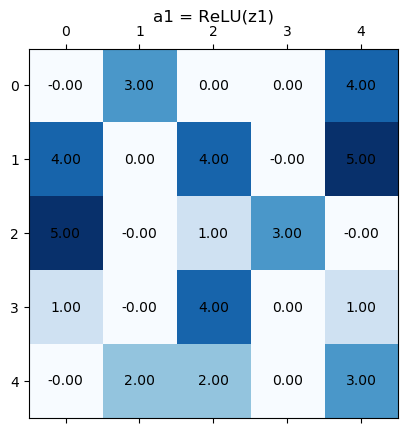

In [124]:
z1 = X.convolve2D(K, bias=b1, stride=1)
z1.draw("z1: I.convolve2D(K, bias=b1, stride=1)")

a1 = Matrix2D(nn.relu(z1.data))
a1.draw("a1 = ReLU(z1)")

#### Maxpool

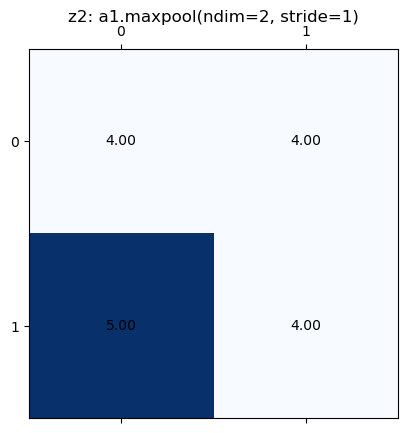

In [125]:
a2, maxpool_indices = a1.maxpool(ndim=2, stride=2)
a2.draw("z2: a1.maxpool(ndim=2, stride=1)")

#### FCNN

In [126]:
a3: Matrix2D = a2.flatten()
#a3.draw("a3: a2.flatten()")

z4: float = nn.forward(a3.data)[0, 0]
print(f"z4 = nn.forward(a3) = {z4} ")

a4 = nn.sigmoid(z4)
print(f"a4 = nn.sigmoid(z4) = {a4}")

l = nn.binary_cross_entropy(y, a4)
print(f"loss = nn.binary_cross_entropy(y, a4) = {l}")

z4 = nn.forward(a3) = -6.610591567607221 
a4 = nn.sigmoid(z4) = 0.0013442262662906566
loss = nn.binary_cross_entropy(y, a4) = 2.8715276227028026


# Backward pass

In [144]:
learning_rate = 0.2

nn.backward = True # Make sure to set the network to backward pass now

# Chain rule backwards in the network
delta = nn.binary_cross_entropy(y, a4) * nn.sigmoid(z4)
nn.bias -= learning_rate * delta # Update bias for the FCNN

delta = delta * a3.data 
nn.weights -= learning_rate * delta.T # Update weights for the FCNN

# Undo the flattening operation
#delta = delta.reshape(a2.data.shape)

# Calculate the derivative through the maxpool operation
delta_temp = np.zeros_like(a1.data)
for max_indices, gradient in zip(maxpool_indices, delta):
    delta_temp[max_indices] = gradient
delta = delta_temp

# Derivative through the ReLU activation
#Matrix2D(delta).draw()
delta = nn.relu(delta) * delta
#Matrix2D(delta).draw()

# Derivative through the convolution operation
grad_b1 = delta.sum()
grad_kernel = X.convolve2D(Matrix2D(delta))


# Update weights and biase for convolution
K.data -= learning_rate * grad_kernel.data
b1 -= learning_rate * grad_b1


/tmp/ipykernel_56844/664669164.py:115: RuntimeWarning: invalid value encountered in greater
  act = value > 0


# Train the network automatically!
Since the problem description is framed as a classification problem between images generated from two different distributions, it is fairly easy to generate new labelled datasets automatically, and thus automatically train the network. The section below shows how this can be done.

In [175]:
# parameters
K = Matrix2D(np.array(([[1, -1, 1], [0, 0, 0], [-1, 1, -1]]),  dtype=np.float64)) # TODO: Initialize random???
b1 = 1.0

# Learned parameters for the FNN
w = np.random.uniform(low=-1, high=1, size=(1, 4))
b2 = 1.0

# Initialize network
nn = Network(weights=w, bias = b2)

def do_forward_pass(X, y, K, b, test=False):
    nn.backward = False

    z1 = X.convolve2D(K, bias=b, stride=1)
    a1 = Matrix2D(nn.relu(z1.data))

    a2, maxpool_indices = a1.maxpool(ndim=2, stride=2)
    a3: Matrix2D = a2.flatten()

    z4: float = nn.forward(a3.data)[0, 0]
    a4 = nn.sigmoid(z4)

    l = nn.binary_cross_entropy(y, a4)
    print(f"loss: {l}")
    print(f"Prob. class 0: {1 - a4}")
    print(f"Prob. class 1: {a4}")
    print(f"Actual class: {y}")

    return a4, z4, a3, a1


def do_backward_pass(X, y, a4, z4, a3, a1): 
    nn.backward = True
    delta = nn.binary_cross_entropy(y, a4) * nn.sigmoid(z4)
    db2 = delta # Update bias for the FCNN

    delta = delta * a3.data 
    dw = delta.T # Update weights for the FCNN

    delta_temp = np.zeros_like(a1.data)
    for max_indices, gradient in zip(maxpool_indices, delta):
        delta_temp[max_indices] = gradient
    delta = delta_temp

    delta = nn.relu(delta) * delta

    grad_b1 = delta.sum()
    grad_kernel = X.convolve2D(Matrix2D(delta))


    # Update weights and biase for convolution

    return dw, db2, grad_kernel.data, grad_b1


# Generate n/2 samples of each class to train in
n_training_samples = 10
classes = np.concatenate((np.ones(n_training_samples // 2), np.zeros(n_training_samples // 2)))
np.random.shuffle(classes)

ndim = 7
learning_rate = 0.0001
for y in classes: 

    if y == 0:
        X = Matrix2D(np.random.normal(0, 1, (ndim, ndim)))
    else:
        X = Matrix2D(np.random.poisson(1.0, (ndim, ndim)))

    a4, z4, a3, a1 = do_forward_pass(X, y, K, b1)
    dw, db2, dK, db1 = do_backward_pass(X, y, a4, z4, a3, a1)
    nn.weights -= learning_rate * dw
    nn.bias -= learning_rate * db2

    K.data -= learning_rate * dK
    b1 -= learning_rate * db1

loss: 0.00010797963180786378
Prob. class 0: 0.00024860138410132127
Prob. class 1: 0.9997513986158987
Actual class: 1.0
loss: 1.6834974181921407
Prob. class 0: 0.020725383804390374
Prob. class 1: 0.9792746161956096
Actual class: 0.0
loss: 2.3075662258734106
Prob. class 0: 0.004925312311861774
Prob. class 1: 0.9950746876881382
Actual class: 0.0
loss: 0.004406140209360621
Prob. class 0: 0.010094220657225206
Prob. class 1: 0.9899057793427748
Actual class: 1.0
loss: 0.0005709588076096534
Prob. class 0: 0.0013138174243239042
Prob. class 1: 0.9986861825756761
Actual class: 1.0
loss: 0.0022881397250256764
Prob. class 0: 0.0052547814995220765
Prob. class 1: 0.9947452185004779
Actual class: 1.0
loss: 2.945957929680405
Prob. class 0: 0.0011325100647278097
Prob. class 1: 0.9988674899352722
Actual class: 0.0
loss: 0.02624924260005636
Prob. class 0: 0.058650800996123076
Prob. class 1: 0.9413491990038769
Actual class: 1.0
loss: 3.242318056058734
Prob. class 0: 0.0005723766967284938
Prob. class 1: 0.9

In [179]:
# Evaluate new sample!

X = Matrix2D(np.random.normal(0, 1, (ndim, ndim)))

K = Matrix2D(np.array(([[0.95442787, -1.13157498,  0.87925733], [-0.02156161, -0.16743848, -0.16883059], [-1.05058043,  1.075205,   -0.94628099]]),  dtype=np.float64))
b1 = 5.857627689867563

# Learned parameters for the FNN
w = np.array([[-0.08943661, -0.02658858, -0.44652234, -0.38775535]])
b2 = 0.14747453317699497

# Initialize network
nn = Network(weights=w, bias = b2)

do_forward_pass(X, y, K, b1)

# Trained network:
Network parameters: K = [ 0.95442787 -1.13157498  0.87925733
                         -0.02156161 -0.16743848 -0.16883059
                         -1.05058043  1.075205   -0.94628099]
b1 = -5.857627689867563
 
w = [-0.08943661 -0.02658858 -0.44652234 -0.38775535]
b2 = 0.14747453317699497